# Capstone Project : COVID-19 Predictions II
---
Using the Kaggle dataset to forecast confirmed cases and fatalities between April 15 and May 14.

---


#### Import Tools & Datasets

In [1]:
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
# import matplotlib.colors as mcolors
import seaborn as sns
sns.set()  # Set style & figures inline

import requests
import time
from bs4 import BeautifulSoup
import numpy as np 
import pandas as pd 
import random
import math
import time
import datetime
# import operator 

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

plt.style.use('fivethirtyeight')
%matplotlib inline


C:\Users\domin\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# importing datetime formatted training and test dataset that was previously created
train = pd.read_csv('./datasets/kaggle_data/train.csv')
test = pd.read_csv('./datasets/kaggle_data/test.csv')

---
### Training Models
---
Using datetime features

In [3]:
train.tail(10)

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
29725,35654,NaN,Zimbabwe,2020-04-16,23.0,3.0
29726,35655,NaN,Zimbabwe,2020-04-17,24.0,3.0
29727,35656,NaN,Zimbabwe,2020-04-18,25.0,3.0
29728,35657,NaN,Zimbabwe,2020-04-19,25.0,3.0
29729,35658,NaN,Zimbabwe,2020-04-20,25.0,3.0
29730,35659,NaN,Zimbabwe,2020-04-21,28.0,3.0
29731,35660,NaN,Zimbabwe,2020-04-22,28.0,4.0
29732,35661,NaN,Zimbabwe,2020-04-23,28.0,4.0
29733,35662,NaN,Zimbabwe,2020-04-24,29.0,4.0
29734,35663,NaN,Zimbabwe,2020-04-25,31.0,4.0


In [4]:
test.tail()

,ForecastId,Province_State,Country_Region,Date
13454,13455,NaN,Zimbabwe,2020-05-10
13455,13456,NaN,Zimbabwe,2020-05-11
13456,13457,NaN,Zimbabwe,2020-05-12
13457,13458,NaN,Zimbabwe,2020-05-13
13458,13459,NaN,Zimbabwe,2020-05-14


In [5]:
train.columns = map(str.lower, train.columns)
test.columns = map(str.lower, test.columns)

In [6]:
train['date']= pd.to_datetime(train['date'], errors='coerce') 
test['date']= pd.to_datetime(test['date'], errors='coerce') 

In [7]:
# feature engineering new columns from datetime format for train set
train['day'] = train['date'].dt.day
train['month'] = train['date'].dt.month
train['dayofweek'] = train['date'].dt.dayofweek
train['dayofyear'] = train['date'].dt.dayofyear
train['quarter'] = train['date'].dt.quarter
train['weekofyear'] = train['date'].dt.weekofyear

# feature engineering new columns from datetime format for test set
test['day'] = test['date'].dt.day
test['month'] = test['date'].dt.month
test['dayofweek'] = test['date'].dt.dayofweek
test['dayofyear'] = test['date'].dt.dayofyear
test['quarter'] = test['date'].dt.quarter
test['weekofyear'] = test['date'].dt.weekofyear

countries = list(train['country_region'].unique())
sg_code = countries.index('Singapore')
# train = train.drop(['date','Lat', 'Long'],1)
# test =  test.drop(['date','Lat', 'Long'],1)

# fill countries without province/state data with NaN
train["province_state"].fillna('NaN', inplace=True)
test["province_state"].fillna('NaN', inplace=True)

# instantiate ordinal encoder
# https://datascience.stackexchange.com/questions/39317/difference-between-ordinalencoder-and-labelencoder
oe = OrdinalEncoder()

# assigning float value to corresponding country and province/state including NaN (somewhat dummifying for features)
train[['province_state','country_region']] = oe.fit_transform(train.loc[:,['province_state','country_region']])
test[['province_state','country_region']] = oe.fit_transform(test.loc[:,['province_state','country_region']])

---
#### For Confirmed Cases

In [8]:
train_columns = ['day','month','dayofweek','dayofyear','quarter','weekofyear','province_state','country_region','confirmedcases', 'fatalities']
train = train[train_columns]
test_columns = ['day','month','dayofweek','dayofyear','quarter','weekofyear','province_state','country_region']
test_model = test[test_columns]

X = train.drop(['confirmedcases', 'fatalities'], axis=1)
y = train['confirmedcases']
X_train, X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
test_sg = test_model[test_model['country_region'] == sg_code]

In [9]:
models = []
mse = []
rmse = []
rmsle = []

In [10]:
# linear regression model
lm = LinearRegression(normalize=True, fit_intercept=True)
lm.fit(X_train, y_train)

pred = lm.predict(X_test)
lm_forecast_cc = lm.predict(test_model)

models.append('Linear Regression')
mse.append(round(mean_squared_error(pred, y_test),2))
rmse.append(round(np.sqrt(mean_squared_error(pred, y_test)),2))
# rmsle.append(round(np.sqrt(mean_squared_log_error(pred, y_test)),2))

In [11]:
# random forest regression model
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train,y_train)

pred = rf.predict(X_test)
rfr_forecast_cc = rf.predict(test_model)

models.append('Random Forest')
mse.append(round(mean_squared_error(pred, y_test),2))
rmse.append(round(np.sqrt(mean_squared_error(pred, y_test)),2))
# rmsle.append(round(np.sqrt(mean_squared_log_error(pred, y_test)),2))

In [12]:
xgb_test = test[['day', 'month', 'dayofweek', 'dayofyear', 'quarter', 'weekofyear', 'province_state','country_region']]
# xgboost regression model
xgb = XGBRegressor(n_estimators=100)
xgb.fit(X_train,y_train)

pred = xgb.predict(X_test)
xgb_forecast_cc = xgb.predict(test_model)

models.append('XGBoost')
mse.append(round(mean_squared_error(pred, y_test),2))
rmse.append(round(np.sqrt(mean_squared_error(pred, y_test)),2))

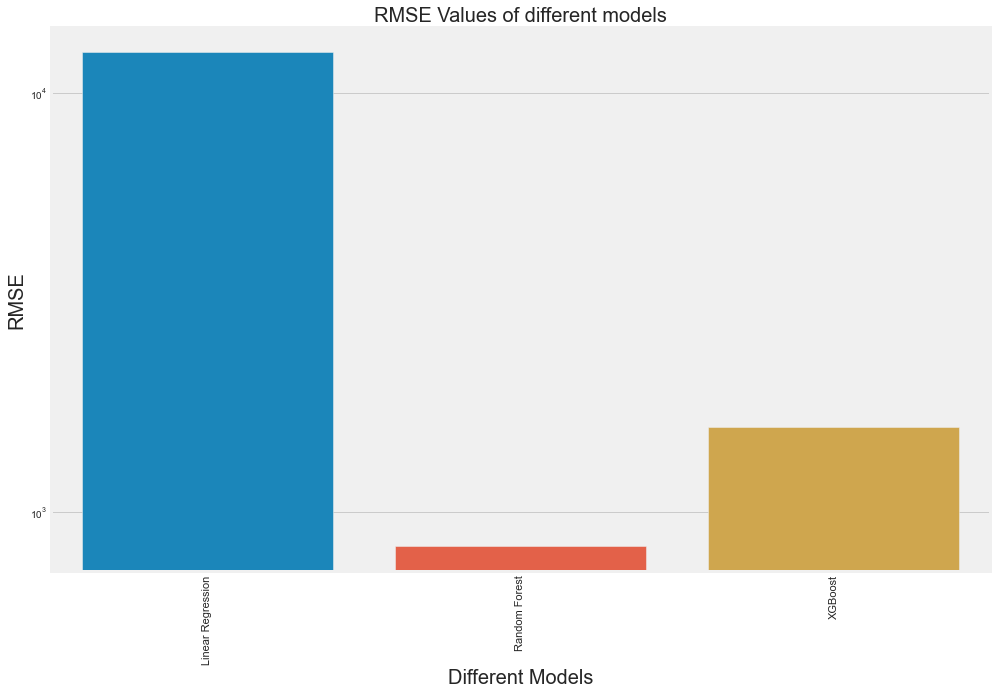

In [13]:
plt.figure(figsize= (15,10))
plt.xticks(rotation = 90 ,fontsize = 11)
plt.yticks(fontsize = 10)
plt.xlabel("Different Models",fontsize = 20)
plt.ylabel('RMSE',fontsize = 20)
plt.title("RMSE Values of different models" , fontsize = 20)
sns.barplot(x=models,y=rmse, log=True);

In [14]:
compare = pd.DataFrame(np.column_stack([models, mse, rmse]), columns=['model', 'mse', 'rmse'])
compare

,model,mse,rmse
0,Linear Regression,157470458.21,12548.72
1,Random Forest,687457.82,829.13
2,XGBoost,2543786.22,1594.93


---
#### For Fatalities

In [15]:
train_columns = ['day','month','dayofweek','dayofyear','quarter','weekofyear','province_state','country_region','confirmedcases', 'fatalities']
train = train[train_columns]
test_columns = ['day','month','dayofweek','dayofyear','quarter','weekofyear','province_state','country_region']
test_model = test[test_columns]

X = train.drop(['confirmedcases', 'fatalities'], axis=1)
y = train['fatalities']
X_train, X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
test_sg = test_model[test_model['country_region'] == sg_code]

In [16]:
models = []
mse = []
rmse = []
rmsle = []

In [17]:
# linear regression model
lm = LinearRegression(normalize=True, fit_intercept=True)
lm.fit(X_train, y_train)

pred = lm.predict(X_test)
lm_forecast_f = lm.predict(test_model)

models.append('Linear Regression')
mse.append(round(mean_squared_error(pred, y_test),2))
rmse.append(round(np.sqrt(mean_squared_error(pred, y_test)),2))
# rmsle.append(round(np.sqrt(mean_squared_log_error(pred, y_test)),2))

In [18]:
# random forest regression model
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train,y_train)

pred = rf.predict(X_test)
rfr_forecast_f = rf.predict(test_model)

models.append('Random Forest')
mse.append(round(mean_squared_error(pred, y_test),2))
rmse.append(round(np.sqrt(mean_squared_error(pred, y_test)),2))
# rmsle.append(round(np.sqrt(mean_squared_log_error(pred, y_test)),2))

In [19]:
xgb_test = test_model[['day', 'month', 'dayofweek', 'dayofyear', 'quarter', 'weekofyear', 'province_state','country_region']]
# xgboost regression model
xgb = XGBRegressor(n_estimators=100)
xgb.fit(X_train,y_train)

pred = xgb.predict(X_test)
xgb_forecast_f = xgb.predict(xgb_test)

models.append('XGBoost')
mse.append(round(mean_squared_error(pred, y_test),2))
rmse.append(round(np.sqrt(mean_squared_error(pred, y_test)),2))

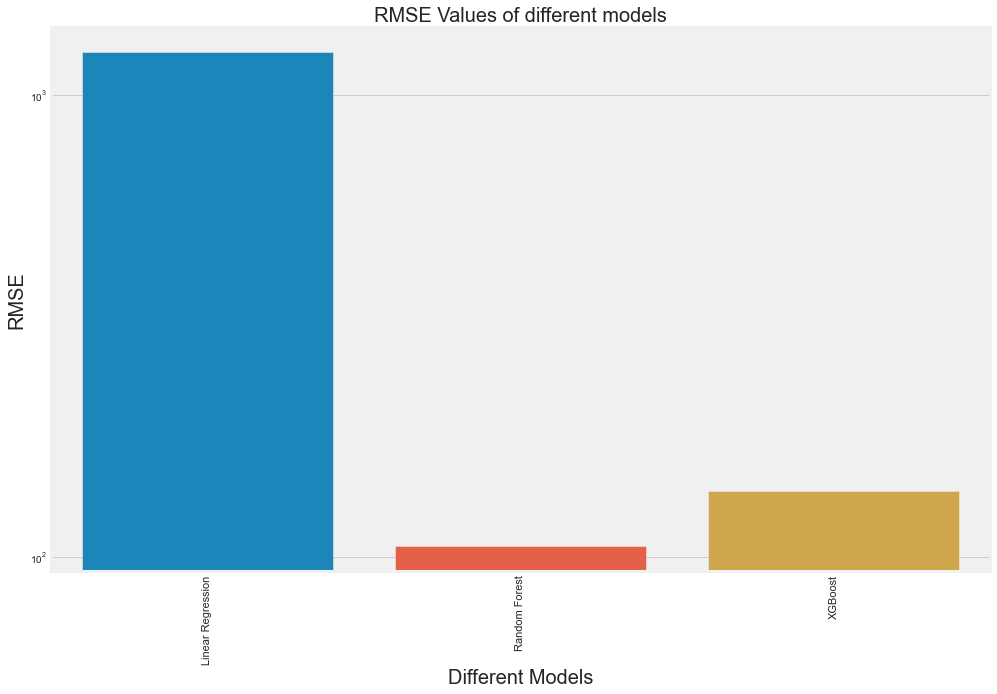

In [20]:
plt.figure(figsize= (15,10))
plt.xticks(rotation = 90 ,fontsize = 11)
plt.yticks(fontsize = 10)
plt.xlabel("Different Models",fontsize = 20)
plt.ylabel('RMSE',fontsize = 20)
plt.title("RMSE Values of different models" , fontsize = 20)
sns.barplot(x=models,y=rmse, log=True);

In [21]:
compare = pd.DataFrame(np.column_stack([models, mse, rmse]), columns=['model', 'mse', 'rmse'])
compare

,model,mse,rmse
0,Linear Regression,1529577.74,1236.76
1,Random Forest,11173.06,105.7
2,XGBoost,19406.37,139.31


---
#### Kaggle subission

In [22]:
test2 = pd.read_csv('./datasets/kaggle_data/test.csv')

In [23]:
# creating dataframe for predicted sales price for kaggle submission
submission = pd.DataFrame({'ConfirmedCases':rfr_forecast_cc, 
                           'Fatalities':rfr_forecast_f}, 
                          columns=['ConfirmedCases', 'Fatalities'])
submission['ForecastId'] = test2['ForecastId']
submission = submission[['ForecastId', 'ConfirmedCases', 'Fatalities']]
submission.head()

,ForecastId,ConfirmedCases,Fatalities
0,1,275.97,8.04
1,2,331.59,9.34
2,3,314.44,7.84
3,4,360.40,15.88
4,5,429.02,17.87


In [24]:
submission.to_csv('./datasets/kaggle_data/latest_data.csv', index=False)


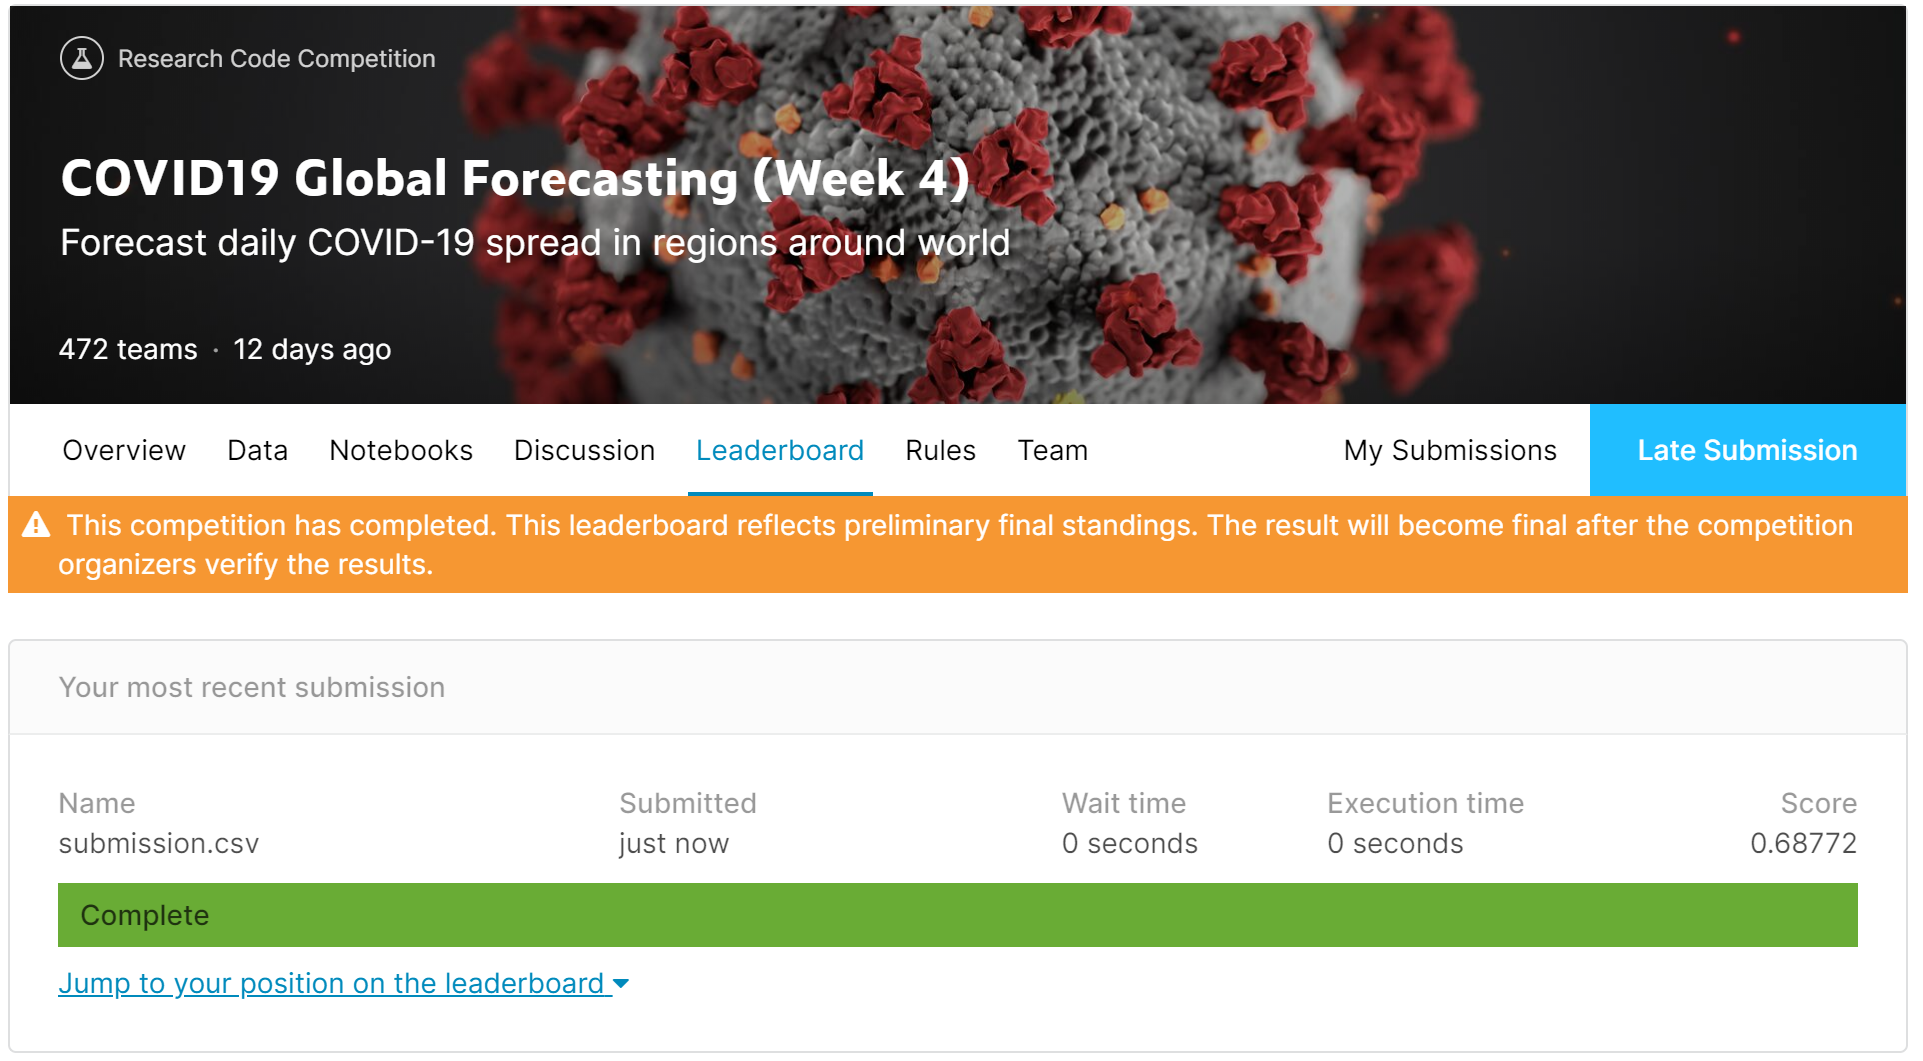

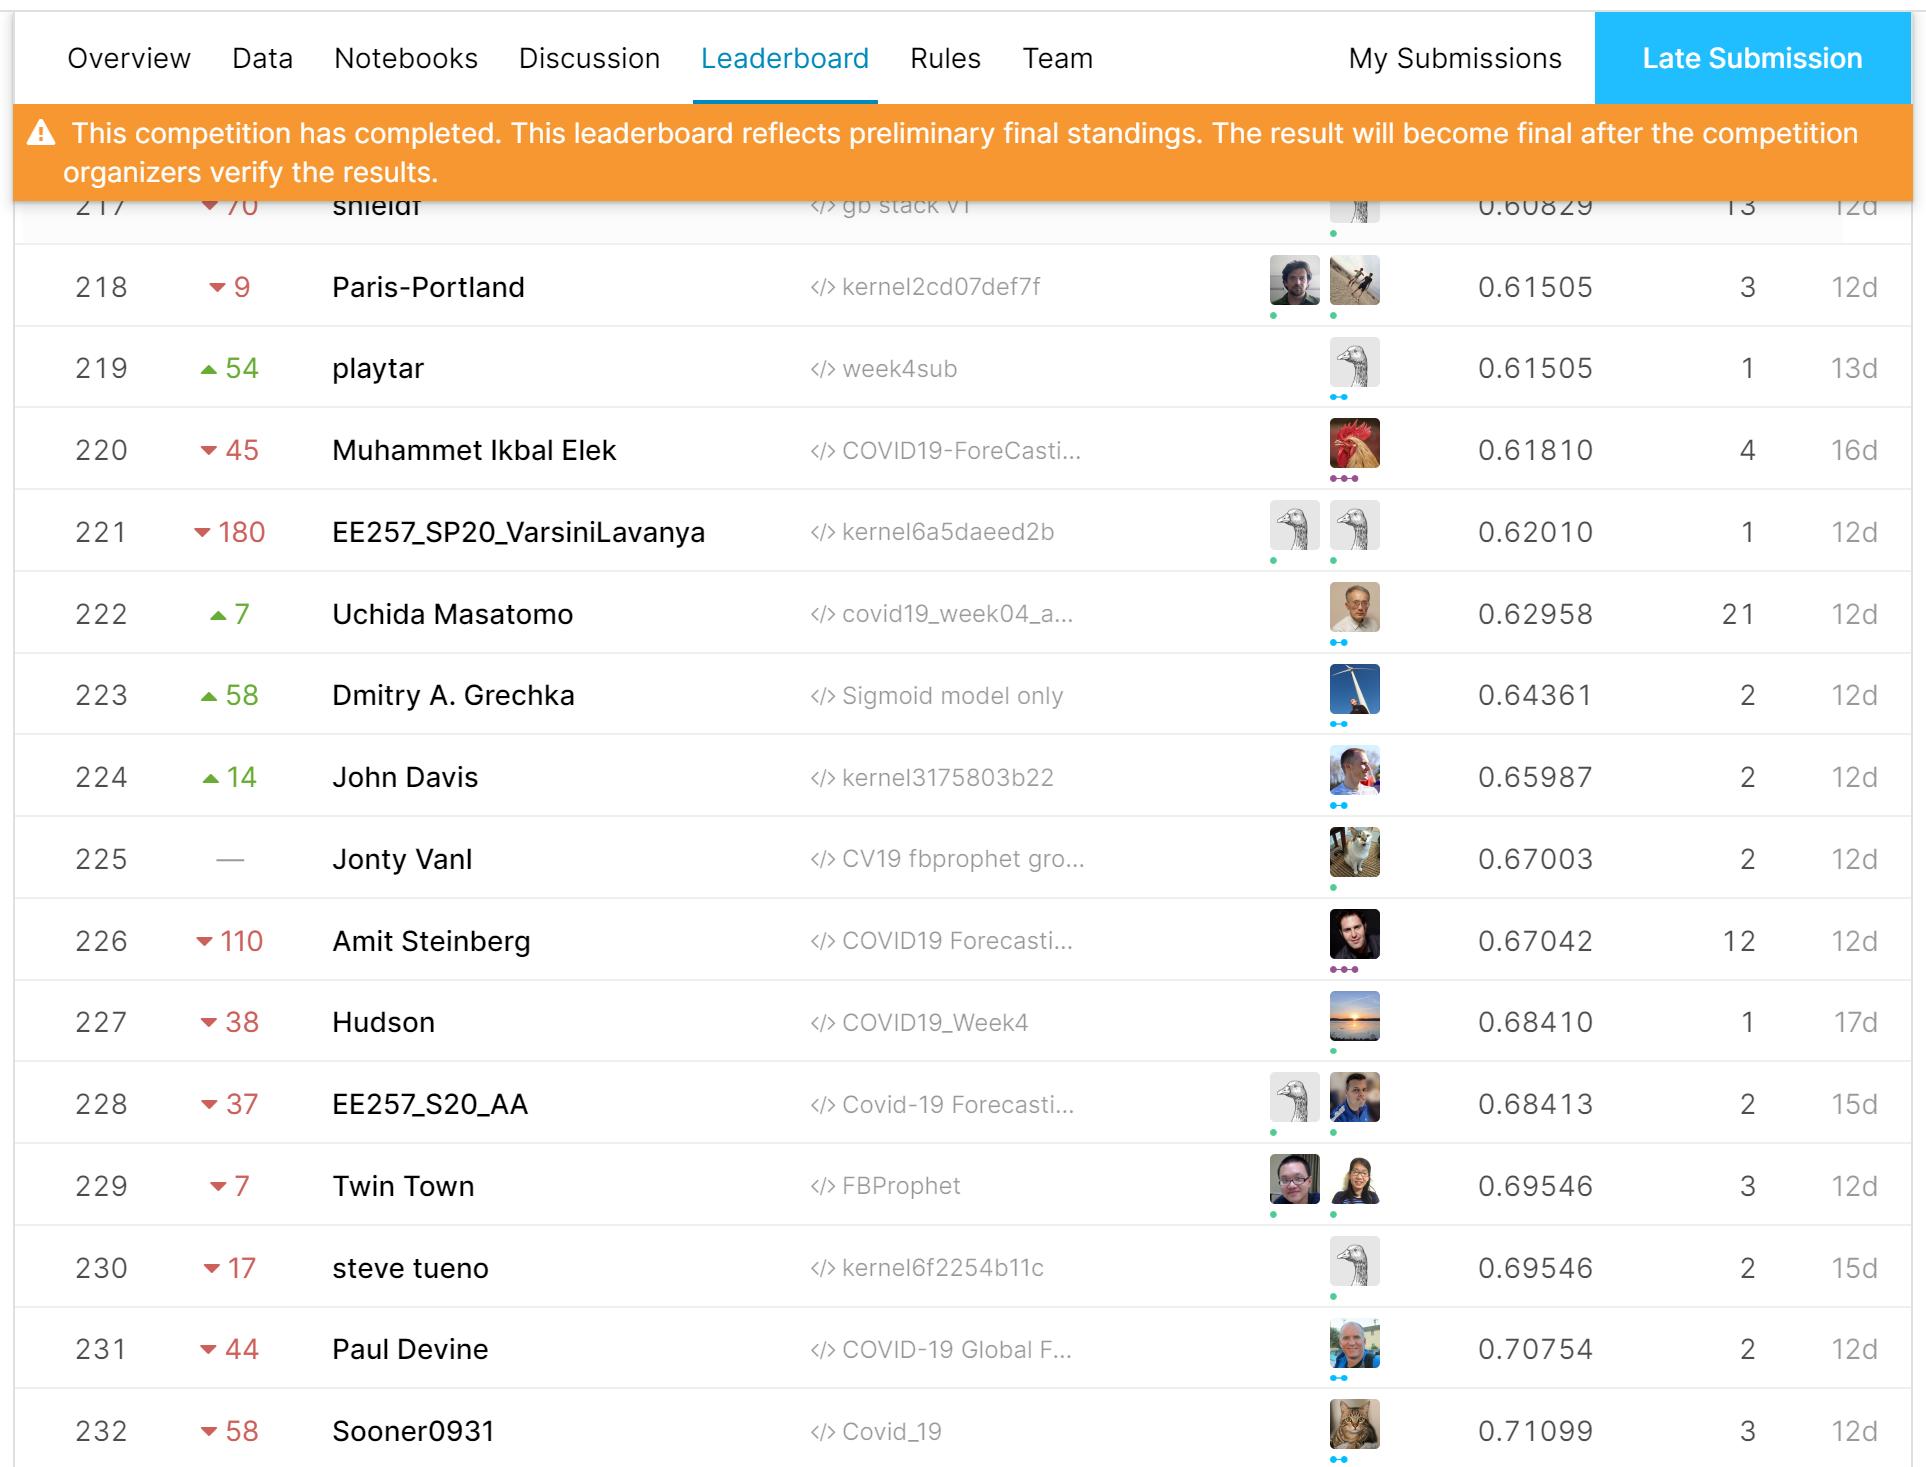